In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import sqlite3
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import pandas as pd
import pycaret
pycaret.__version__

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [2]:
pip install torch

^C
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Подключение к базе данных
conn = sqlite3.connect('../db/normalized_data.db')
cursor = conn.cursor()

# Извлечение данных из столбца job_name_norm
cursor.execute("SELECT job_name_norm FROM jobs")
rows = cursor.fetchall()
sentences = [row[0] for row in rows]

# Закрытие соединения с базой данных
conn.close()

In [23]:
# Загрузка модели BERT
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# Токенизация предложений
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

# Вычисление токенов
with torch.no_grad():
    model_output = model(**encoded_input)


KeyboardInterrupt



In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
# Проведение кластеризации методом к-ближайших соседей
vectorizer = TfidfVectorizer()
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
X = sentence_embeddings.numpy()

545 0.69827056
550 0.69892514
Лучшее количество кластеров: 550 с силуэтным коэффициентом: 0.6989251375198364


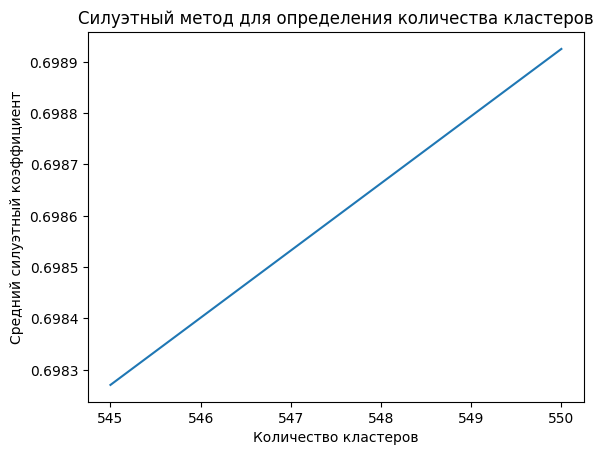

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Подготовка данных (X - это ваш датасет)
# ...

# Определение диапазона количества кластеров для оценки
range_n_clusters = range(545, 551, 5)  # Например, от 2 до 10

best_n_clusters = 0
best_silhouette = -1

# Список для хранения средних силуэтных коэффициентов
silhouette_avg_scores = []

# Оценка моделей K-средних для разных количеств кластеров
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(n_clusters, silhouette_avg)
    # Сохранение лучшего результата
    if silhouette_avg > best_silhouette:
        best_n_clusters = n_clusters
        best_silhouette = silhouette_avg

print(f'Лучшее количество кластеров: {best_n_clusters} с силуэтным коэффициентом: {best_silhouette}')

# Построение графика силуэтных коэффициентов
plt.plot(range_n_clusters, silhouette_avg_scores)
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэтный коэффициент')
plt.title('Силуэтный метод для определения количества кластеров')
plt.show()

C:\Users\alexx\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


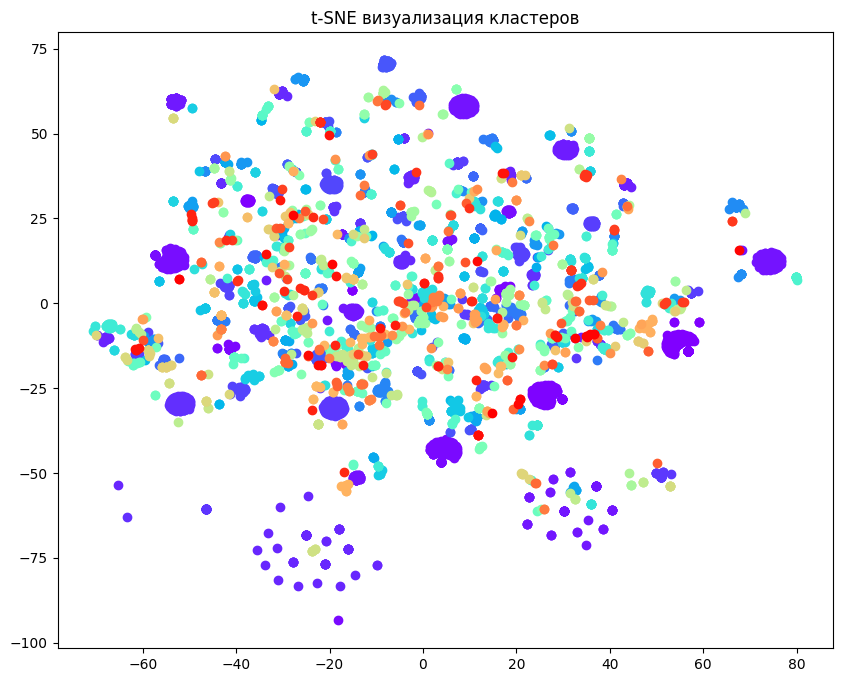

In [65]:
# Проведение кластеризации с оптимальным количеством кластеров
optimal_clusterer = KMeans(n_clusters=best_n_clusters, random_state=42)
optimal_cluster_labels = optimal_clusterer.fit_predict(X)

# Визуализация результатов (если применимо)
# Можно использовать t-SNE для снижения размерности, если X имеет больше двух измерений
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

colors = plt.cm.rainbow(np.linspace(0, 1, best_n_clusters))
plt.figure(figsize=(10, 8))
for i in range(best_n_clusters):
    plt.scatter(X_tsne[optimal_cluster_labels == i, 0], X_tsne[optimal_cluster_labels == i, 1], color=colors[i], label=f'Cluster {i}')
plt.title('t-SNE визуализация кластеров')
plt.show()

In [66]:
df = pd.DataFrame({'Профессия': sentences, 'Кластер': optimal_cluster_labels})

In [67]:
df

,Профессия,Кластер
0,ветеринарный врач,2
1,ветеринарный врач,2
2,тракторист-машинист,27
3,тракторист-машинист,27
4,агроном,7
...,...,...
4330,старший инженер,103
4331,зоотехник,16
4332,зоотехник,16
4333,помощник зоотехника по кормлению,125


In [68]:
# Подключение к базе данных для сохранения сниппета
db_path_norm = "../db//normalized_data.db"
conn_norm = sqlite3.connect(db_path_norm)

df.to_sql(name='clusters', con=conn_norm, if_exists='replace', index=False)

4335

In [11]:
pip list

^C
Note: you may need to restart the kernel to use updated packages.
Package                   Version
------------------------- ------------
aiohttp                   3.8.5
aiosignal                 1.3.1
ansi2html                 1.8.0
anyio                     4.0.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     23.1.0
Babel                     2.13.1
beautifulsoup4            4.12.2
bleach                    6.1.0
blinker                   1.6.2
browser-cookie3           0.19.1
category-encoders         2.6.3
certifi                   2023.7.22
cffi                      1.15.1
charset-normalizer        3.2.0
click                     8.1.7
cloudpickle               3.0.0
colorama                  0.4.6
comm                      0.2.0
contourpy                 1.2.0
cryptography              41.0.5
curl-cffi     